Team (All 5000 level):

Alex Chan

Pablo Arroliga  

Max Link


## Citations: ##

ChatGPT: https://chat.openai.com/

PML: Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning: Machine Learning and Deep Learning with Python, Scikit-Learn, and Tensorflow 2. Packt Publishing Ltd, 2019.

Dataset: [Steel_Data](https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption/data)





##Preparation and Overview (3 points total)##

**[2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful.**

This is a steel dataset and we are using it to predict the energy demands of a steel production plant. The prediction task is the load type, which should classify the Load Type for a 15 minute period. The Load Types can vary, with 'light', 'medium', 'maximum' being the three types. The types are the energy demand placed on the plant at a certain date and time.

This prediction task can be used to optimize energy efficiency if the energy demands are at certain date-times are known. More resources can be given out at times of maximum load as opposed to times of light load etc. which will optimize energy efficiency. This allocation can save the steel company money on cost of production, & prevent resources from being wasted in production.

Third party values: Electricity comes from the Korea Electric Power Corporation, and if the costs were equal for every incorrect prediction & correct predictions were considered optimal, then there is business value in having high classification accuracy for the Load Types to save electricity. The model would be deployed because the model need to classfying the load type in real time.

One strategy for high accuracy is for the steel company to choose the most common load type 100% of the time. They would pick the 'light_load', being correct 52% of the time.

Logistic regression can be utilized for further optimization, outperforming the 52% and giving us >52% prediction success.

**[.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis (give reasoning). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).**

In [30]:
# imports
import os
import pandas as pd
import numpy as np
# from google.colab import drive

In [31]:
# mount google drive
# drive.mount('/content/drive')

# read the CSV file into csv_data
csv_data = pd.read_csv('/Users/maxlink/Desktop/Steel_industry_data.csv')


# create a df dataframe with the csv_data
df = pd.DataFrame(csv_data)

# display 8 results from data frame indexed starting at 0
df.head(8)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load


In [32]:
# grab the info from the dataframe
# gives column types, how much content is null, content data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [33]:
# group data by type. In this case the load
df_load_type = df.groupby(by='Load_Type')
# count how many of each type of load there are
print(df_load_type['WeekStatus'].count())

Load_Type
Light_Load      18072
Maximum_Load     7272
Medium_Load      9696
Name: WeekStatus, dtype: int64


In [34]:
#find out date column format
csv_data['date'].head(10)

0    01/01/2018 00:15
1    01/01/2018 00:30
2    01/01/2018 00:45
3    01/01/2018 01:00
4    01/01/2018 01:15
5    01/01/2018 01:30
6    01/01/2018 01:45
7    01/01/2018 02:00
8    01/01/2018 02:15
9    01/01/2018 02:30
Name: date, dtype: object

In [35]:
# date column format is: day, month, year, hour, minute
# use format='%d/%m/%Y %H:%M' to properly grab dates
df['Month'] = pd.to_datetime(csv_data['date'], format='%d/%m/%Y %H:%M').dt.month
df['Day'] = pd.to_datetime(csv_data['date'], format='%d/%m/%Y %H:%M').dt.day
df.drop(columns=['date'], inplace = True)

df.head(10)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,Month,Day
0,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,1,1
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,1,1
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,1,1
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,1,1
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load,1,1
5,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load,1,1
6,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load,1,1
7,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load,1,1
8,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load,1,1
9,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load,1,1


In [36]:
# change load types to numeric
df['Load_Type'] = df.Load_Type.map({'Light_Load': 0,
                                    'Medium_Load': 1,
                                    'Maximum_Load': 2})

df['WeekStatus'] = df.WeekStatus.map({'Weekday': 0,
                                      'Weekend': 1})

one_hot = pd.get_dummies(df['Day_of_week'])
df = df.join(one_hot)
df.drop(columns=['Day_of_week'], inplace=True)

df.head(10)

# is there a way to get friday & all the days after Friday to display as True or False?
# clearer chart? Or not necessasry?

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type,Month,Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,3.17,2.95,0.0,0.0,73.21,100.0,900,0,0,1,1,False,True,False,False,False,False,False
1,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,0,1,1,False,True,False,False,False,False,False
2,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,0,1,1,False,True,False,False,False,False,False
3,3.31,3.56,0.0,0.0,68.09,100.0,3600,0,0,1,1,False,True,False,False,False,False,False
4,3.82,4.50,0.0,0.0,64.72,100.0,4500,0,0,1,1,False,True,False,False,False,False,False
5,3.28,3.56,0.0,0.0,67.76,100.0,5400,0,0,1,1,False,True,False,False,False,False,False
6,3.60,4.14,0.0,0.0,65.62,100.0,6300,0,0,1,1,False,True,False,False,False,False,False
7,3.60,4.28,0.0,0.0,64.37,100.0,7200,0,0,1,1,False,True,False,False,False,False,False
8,3.28,3.64,0.0,0.0,66.94,100.0,8100,0,0,1,1,False,True,False,False,False,False,False
9,3.78,4.72,0.0,0.0,62.51,100.0,9000,0,0,1,1,False,True,False,False,False,False,False


**Pre-processed Dataframe:**

Nine new columns created as a different way to hold the day, month, & weekday values.

Extracted the month & day from the date column to use these values in our model.

One-hot encoded the "day_of_week" column to have its own column for each day of the week that can either be a 0 or a 1.

Converted the Load_Type & WeekStatus were mapped to integers to convert them from text to integer values.

**Statistical breakdown of values in each column below:**

In [37]:
# print a table that shows the mean of properties
df.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type,Month,Day
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000,0.284932,0.691781,6.526027,15.720548
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317,0.451388,0.792658,3.447901,8.796373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000,0.000000,0.000000,4.000000,8.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000,0.000000,0.000000,7.000000,16.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000,1.000000,1.000000,10.000000,23.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000,1.000000,2.000000,12.000000,31.000000


This above table shows the mean, std, max, min, and quartiles for numeric features like the tract kWh, kVarh, tCO2, leading and lagging current power factor, and NSM.

The data related features came out correctly as the days of the week share an equal distribution, shown by the shared mean of ~ 0.142.

values of months & days range between 1 and 31 for day, and 1 to 12 for month.

The Load_Type prediction column has a lower quartile, median, and mean less than 1, which shows that the most common Load_Type is 0. 0 was originally 'light_load'.

In [38]:
norm_features = ['Usage_kWh',
                 'Lagging_Current_Reactive.Power_kVarh',
                 'Leading_Current_Reactive_Power_kVarh',
                 'Lagging_Current_Power_Factor',
                 'Leading_Current_Power_Factor',
                 'NSM',
                 'Month',
                 'Day'
                 ]

# setting the norm_features column
# set to norm_features - norm_features.mean() / df[norm_features].std()
df[norm_features] = (df[norm_features]-df[norm_features].mean()) / df[norm_features].std()

# display first 10 items
df.head(10)


,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type,Month,Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-0.724095,-0.618508,-0.521378,0.0,-0.389405,0.51326,-1.677991,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
1,-0.699277,-0.525904,-0.521378,0.0,-0.729762,0.51326,-1.641905,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
2,-0.722002,-0.598270,-0.521378,0.0,-0.544257,0.51326,-1.605820,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
3,-0.719908,-0.581098,-0.521378,0.0,-0.659999,0.51326,-1.569734,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
4,-0.704659,-0.523450,-0.521378,0.0,-0.838105,0.51326,-1.533648,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
5,-0.720805,-0.581098,-0.521378,0.0,-0.677440,0.51326,-1.497562,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
6,-0.711237,-0.545528,-0.521378,0.0,-0.790540,0.51326,-1.461476,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
7,-0.711237,-0.536942,-0.521378,0.0,-0.856603,0.51326,-1.425390,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
8,-0.720805,-0.576192,-0.521378,0.0,-0.720777,0.51326,-1.389305,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False
9,-0.705855,-0.509959,-0.521378,0.0,-0.954905,0.51326,-1.353219,0,0,-1.602722,-1.673479,False,True,False,False,False,False,False


In [39]:
# shuffles data frame & drops old index.
# Shuffling prepares for training & running data
df = df.sample(frac = 1, random_state=42).reset_index(drop = True)
# display first 10 items in every column
df.head(10)

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type,Month,Day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-0.732766,-0.565153,-0.521378,0.00,-1.076989,0.513260,-0.667588,1,0,-0.732628,1.509651,False,False,False,True,False,False,False
1,0.998168,2.145506,-0.521378,0.03,-0.111940,0.513260,0.018043,0,2,1.007562,-1.332430,False,False,False,False,True,False,False
2,2.781726,2.858740,-0.521378,0.06,0.477342,0.513260,-0.054129,0,2,-1.602722,1.168601,True,False,False,False,False,False,False
3,-0.725291,-0.799423,1.714474,0.00,1.026458,-2.161699,0.378901,1,0,-0.152565,-1.559796,False,False,True,False,False,False,False
4,0.941058,0.487834,-0.521378,0.03,0.719397,0.513260,0.451073,0,1,1.587625,-0.991380,True,False,False,False,False,False,False
5,-0.726188,-0.585391,-0.521378,0.00,-0.748788,0.513260,-0.848017,0,0,-1.022659,1.168601,False,True,False,False,False,False,False
6,-0.537815,-0.799423,2.242459,0.00,1.026458,-1.402585,0.162386,0,1,1.587625,0.259135,False,False,False,False,False,True,False
7,-0.711237,-0.593977,-0.521378,0.00,-0.389405,0.513260,-1.605820,0,0,-0.732628,0.259135,False,False,False,False,False,False,True
8,-0.681038,-0.664503,-0.511949,0.00,0.511166,0.512932,1.677991,0,0,1.297593,0.827552,True,False,False,False,False,False,False
9,-0.705855,-0.607469,-0.506562,0.00,-0.188045,0.511947,-1.714077,1,0,1.587625,-0.877697,False,False,True,False,False,False,False


**[.5 points] Divide your data into training and testing splits using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?**  

**80/20 Split:**

The 80/20 split is common in machine learning models. Here, 80% of the data is used as training data, and 20% of the data is ran through the model as test data.

With large datasets, an 80/20 split increases the percentage of training data, which finds subtle patterns.

Increasing the training data available makes the model take longer to run, but yeilds a higher accuracy on the test data. Decreasing the training data amounts to a faster model with a lower accuracy score on the test data. This percentage can be split into different ratios to find the best combination of training and testing data.

We settled on the 80/20 split for this dataset as we found that it provided the best tradeoff between model performance & runtime.

In [40]:
from sklearn.model_selection import ShuffleSplit # for splitting
from sklearn import metrics as mt # ????

# function for training the data
def train_test_split(lr_clf):
  for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices], y[train_indices]) #train object
    y_hat = lr_clf.predict(X[test_indices]) # get the test set predictions

    # print the accuracy
    print("==== Iteration", iter_num, "====")
    print("accuracy", mt.accuracy_score(y[test_indices], y_hat))
    print("confusion matrix\n", mt.confusion_matrix(y[test_indices], y_hat))

In [41]:
# create X & convert to numpy array as floats
X = df[['Usage_kWh',
        'Lagging_Current_Reactive.Power_kVarh',
        'Leading_Current_Reactive_Power_kVarh',
        'CO2(tCO2)',
        'Lagging_Current_Power_Factor',
        'Leading_Current_Power_Factor',
        'NSM',
        'WeekStatus',
        'Month',
        'Day',
        'Friday',
        'Monday',
        'Saturday',
        'Sunday',
        'Thursday',
        'Tuesday',
        'Wednesday'
        ]].to_numpy().astype(float)

# create y by giving it Load_Type, convert to numpy array
y = df['Load_Type'].to_numpy()

In [42]:
# grab an instance for cross validation object in scikit learn
num_cv_iterations = 1
num_instances = len(y)

# perform a split on the data
# 80/20 split
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size = 0.2, train_size=0.8)

# display the cv_object to validate that everything is correct
print(cv_object)

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=0.8)


## Modeling with Logistic Regression: (5 points total)##

**[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and Newton's method. It is recommended to call this the "solver" input for the class.
Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.**  

In [43]:
from scipy.special import expit
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize_scalar
import copy
from numpy import ma

# logistic regression algo given by including above cells
class BinaryLogisticRegression:
  def __init__(self, eta, iterations=20, C=0.001, penalty='12'):
    self.eta = eta
    self.iters = iterations
    self.C = C
    self.penalty = penalty
    # weights stored as self.w_ to use sklearn conventions

  def __str__(self):
    if(hasattr(self, 'w_')):
      return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_) # successfully trained the object
    else:
      return 'Untrained Binary Logistic Regression Object' # object is untrained

  # bias & sigmoid functions private with @staticmethod
  @staticmethod
  def _add_bias(X):
    return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

  @staticmethod
  def _sigmoid(theta):
    # redefine sigmoid operation to increase stability
    return expit(theta) # 1/(1+np.exp(-theta))

  # vectorize gradient calculation with regularization using L2 Norm
  def _get_gradient(self, X, y):
    ydiff = y-self.predict_proba(X, add_bias=False).ravel() # get y difference
    gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

    gradient = gradient.reshape(self.w_.shape)

    if self.penalty == 'l1': # if the penalty is equal to L 1
      gradient[1:] += -self.C * np.sign(self.w_[1:])
    elif self.penalty == '12':
      gradient[1:] += -2 * self.C * self.w_[1:]
    elif self.penalty == 'elasticnet':
      gradient[1:] += -self.C * np.sign(self.w_[1:]) - 2 * self.C * self.w_[1:]

    return gradient

  # public functions below
  def predict_proba(self, X, add_bias=True):
    # add bias term only if requested
    Xb = self._add_bias(X) if add_bias else X
    return self._sigmoid(Xb @ self.w_) # return probability y=1

  def predict(self, X):
    return (self.predict_proba(X)>0.5) # return the acutal prediction

  def fit(self, X, y):
    Xb = self._add_bias(X) # add bias term
    num_samples, num_features = Xb.shape

    self.w_ = np.zeros((num_features, 1)) # init weight vector to zeroes

    # loop through all iterations
    for _ in range(self.iters):
      gradient = self._get_gradient(Xb, y)
      # multiply by the learning rate
      # add because maximizing
      self.w_ += gradient*self.eta

In [44]:
class StochasticLogisticRegression(BinaryLogisticRegression): # PICK UP HERE BY IMPLEMENTING THIS FUNCTION
  # stochastic gradient calculation
  def _get_gradient(self, X, y):

    # grab a subset of samples in a mini-batch
    # and calculate the gradient according to the small batch only
    mini_batch_size = 16
    idxs = np.random.choice(len(y), mini_batch_size)

    ydiff = y[idxs] - self.predict_proba(X[idxs], add_bias=False).ravel() # get y difference (now scalar)
    gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

    gradient = gradient.reshape(self.w_.shape)

    if self.penalty == 'l1':
      gradient[1:] += -self.C * np.sign(self.w_[1:])
    elif self.penalty == 'l2':
      gradient[1:] += -2 * self.C * self.w_[1:]
    elif self.penalty == 'elasticnet':
      gradient[1:] += -self.C * np.sign(self.w_[1:]) - 2 * self.C * self.w_[1:]


    return gradient

In [45]:
from numpy.linalg import pinv

class HessianBinaryLogisticRegression(BinaryLogisticRegression):
  # overwrite the gradient function
  def _get_gradient(self, X, y):
    # print("HESSIAN ENTERED!") # this is printing so the hessian function is being entered into at least
    g = self.predict_proba(X, add_bias=False).ravel() # get sigmoid value for all classes
    hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

    ydiff = y-g # get y difference
    gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector & multiply through
    gradient = gradient.reshape(self.w_.shape)

    if self.penalty == "l1":
      gradient[1:] += -self.C * np.sign(self.w_[1:])
    elif self.penalty == 'l2':
      gradient[1:] += -2 * self.C * self.w_[1:]
    elif self.penalty == 'elasticnet':
      gradient[1:] += -self.C * np.sign(self.w_[1:]) - 2 * self.C * self.w_[1:]

    return pinv(hessian) @ gradient

In [46]:
# do not perform own BFGS implementation for this next part....
# use scipy implementation of BFGS
from scipy.optimize import fmin_bfgs # most common bfgs algo in the world?
from numpy import ma
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):

  @staticmethod
  def objective_function(w, X, y, C, penalty):
    g = expit(X @ w)
    # invert this because scipy minimizes, but we derived all formulas for maximizing
    return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + C*sum(w**2)
    #-np.sum(y*np.Log(g)+(1-y)*np.Log(1-g))

  @staticmethod
  def objective_gradient(w, X, y, C, penalty):
    g = expit(X @ w)
    ydiff = y-g # get y difference
    gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
    gradient = gradient.reshape(w.shape)

    if penalty == 'l1':
      gradient[1:] += -C * np.sign(w[1:])
    elif penalty == 'l2':
      gradient[1:] += -2 * C * w[1:]
    elif penalty == 'elasticnet':
      gradient[1:] += -C * np.sign(w[1:]) - 2 * C * w[1:]
    return -gradient

  # overwrite the fit function
  def fit(self, X, y):
    Xb = self._add_bias(X) # add the bias term
    num_samples, num_features = Xb.shape

    self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                        np.zeros((num_features, 1)), # the starting point
                        fprime=self.objective_gradient, # gradient function
                        args=(Xb, y, self.C, self.penalty), # extra args for gradient & objective function
                        gtol = 1e-03, # stopping criteria for gradient, |v_k|
                        maxiter=self.iters, # stopping criteria iterations
                        disp=False)

    self.w_ = self.w_.reshape((num_features, 1))




In [47]:
# allow for the user to specify the algo they want to solve the binary case
class MultiClassLogisticRegression:
  def __init__(self, eta, iterations=20,
               C=0.0001,
               penalty='l2',
               solver=BFGSBinaryLogisticRegression):
    self.eta = eta
    self.iters = iterations
    self.C = C
    self.penalty = penalty
    self.solver = solver
    self.classifiers_=[]
    # internally will store weights as self.w_ to keep sklearn conventions

  def __str__(self):
    if(hasattr(self, 'w_')):
      return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_) # object trained
    else:
      return 'Untrained MultiClass Logistic Regression Object'

  def fit(self, X, y):
    num_samples, num_features = X.shape
    self.unique_ = np.sort(np.unique(y)) # get each unique class value
    num_unique_classes = len(self.unique_)
    self.classifiers_ = []
    for i, yval in enumerate(self.unique_): # for each unique value
      y_binary = np.array(y==yval).astype(int) # create a binary problem
      # train the binary classifier for this class

      hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C, penalty=self.penalty)
      hblr.fit(X, y_binary)

      # add the trained classifier to the list
      self.classifiers_.append(hblr)

    # save all the weights into one matrix, separate column for each class
    self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

  def predict_proba(self, X):
    probs = []
    for hblr in self.classifiers_:
      probs.append(hblr.predict_proba(X).reshape((len(X), 1))) # get probability for each classifier

    return np.hstack(probs) # make into single matrix


  def predict(self, X):
    return self.unique_[np.argmax(self.predict_proba(X), axis=1)] # take argmax along row

**[1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated.
Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?**

There is a low likelihood of data snooping because our train/test split is 80/20 and we do a shufflesplit on the data.

**Training**

In [48]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,
                                  iterations=20,
                                  C=0.001,
                                  penalty='l2',
                                  solver=BinaryLogisticRegression
                                  )

train_test_split(lr)

==== Iteration 0 ====
accuracy 0.702054794520548
confusion matrix
 [[2835  539  236]
 [ 189 1006  741]
 [ 122  261 1079]]
CPU times: user 1.12 s, sys: 192 ms, total: 1.31 s
Wall time: 197 ms


In [49]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,
                                  iterations=20,
                                  C=0.001,
                                  penalty='l2',
                                  solver=StochasticLogisticRegression
                                  )
train_test_split(lr)

==== Iteration 0 ====
accuracy 0.697345890410959
confusion matrix
 [[2843  579  187]
 [ 191 1047  722]
 [ 106  336  997]]
CPU times: user 164 ms, sys: 30.6 ms, total: 194 ms
Wall time: 33.7 ms


In [50]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,
                                  iterations=20,
                                  C=0.001,
                                  penalty='l2',
                                  solver=HessianBinaryLogisticRegression
                                  )
train_test_split(lr)

==== Iteration 0 ====
accuracy 0.7587043378995434
confusion matrix
 [[3347  208  100]
 [ 248 1130  514]
 [ 121  500  840]]
CPU times: user 7min 28s, sys: 1min 41s, total: 9min 10s
Wall time: 1min 28s


In [51]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,
                                  iterations=20,
                                  C=0.001,
                                  penalty='l2',
                                  solver=BFGSBinaryLogisticRegression
                                  )
train_test_split(lr)

==== Iteration 0 ====
accuracy 0.7512842465753424
confusion matrix
 [[3285  253  101]
 [ 253 1168  517]
 [ 124  495  812]]
CPU times: user 1.67 s, sys: 184 ms, total: 1.86 s
Wall time: 259 ms


In [52]:
%%time
# use the built in SKLogistic Regression function
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression(solver='liblinear', n_jobs=1,
                             multi_class='ovr', C = 1/0.001,
                             penalty = 'l2', max_iter=20)

train_test_split(lr)

==== Iteration 0 ====
accuracy 0.7656963470319634
confusion matrix
 [[3281  253   95]
 [ 227 1232  463]
 [  96  508  853]]
CPU times: user 1.39 s, sys: 147 ms, total: 1.53 s
Wall time: 215 ms


In [53]:
def lr_explor(cost, eta = 0.1, iterations = 20, penalty='l2', solver=BFGSBinaryLogisticRegression,
              ovr=True):

  if ovr:
    lr_clf = MultiClassLogisticRegression(eta=eta,
                                          iterations=iterations,
                                          C=float(cost),
                                          penalty=penalty,
                                          solver=solver
                                          )
  else:
    lr_clf = MultiClassLogisticRegressionOvO(eta=eta,
                                             iterations=iterations,
                                             C=float(cost),
                                             penalty=penalty,
                                             solver=solver
                                             )
  acc = []
  for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X, y)):
    lr_clf.fit(X[train_indices], y[train_indices]) # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
    acc.append(mt.accuracy_score(y[test_indices], y_hat))

  acc = np.array(acc)
  return acc

**Testing**

In [54]:
%%time
num_cv_iterations = 20
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size=0.2)

costs = np.logspace(-5, 1, 20)
accs=[]
for c in costs:
  accs.append(lr_explor(c, solver=BinaryLogisticRegression))

CPU times: user 4min 50s, sys: 40.2 s, total: 5min 31s
Wall time: 45.2 s


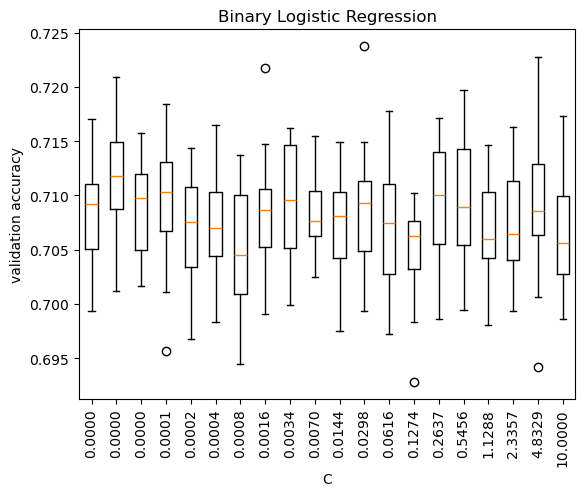

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.title("Binary Logistic Regression")
plt.boxplot(accs)
plt.xticks(range(1, len(costs) + 1), ['%.4f'%(c) for c in costs], rotation='vertical')
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

In [56]:
%%time

costs = np.logspace(-5, 1, 20)
accs=[]
for c in costs:
  accs.append(lr_explor(c, solver=StochasticLogisticRegression))

CPU times: user 18.6 s, sys: 8.2 s, total: 26.8 s
Wall time: 3.58 s


In [57]:
# %%time
# commented out whole cell to continue running program. This cell gets stuck.... 
# costs = np.logspace(-5, 1, 20)
# accs=[]
# for c in costs:
#   accs.append(lr_explor(c, solver=HessianBinaryLogisticRegression))

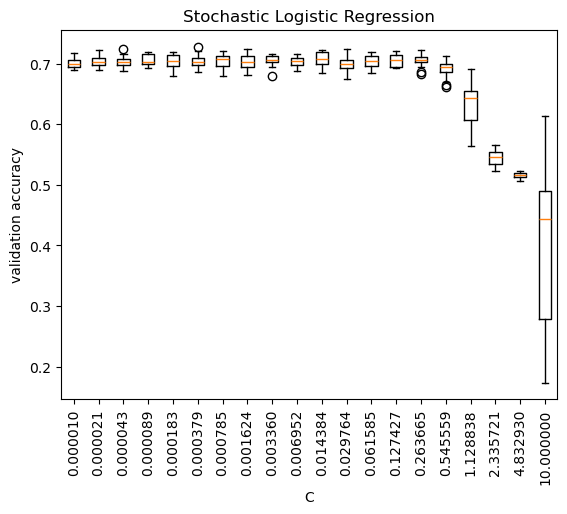

In [58]:
plt.boxplot(accs)
plt.xticks(range(1, len(costs)+1), ['%4f'%(c) for c in costs], rotation='vertical')
plt.title("Stochastic Logistic Regression")
plt.xlabel('C')
plt.ylabel('validation accuracy')
plt.show()

In [59]:
%%time

costs = np.logspace(-5, 1, 20)
accs = []
for c in costs:
  accs.append(lr_explor(c, solver=BFGSBinaryLogisticRegression))

CPU times: user 17min 26s, sys: 2min 7s, total: 19min 34s
Wall time: 2min 40s


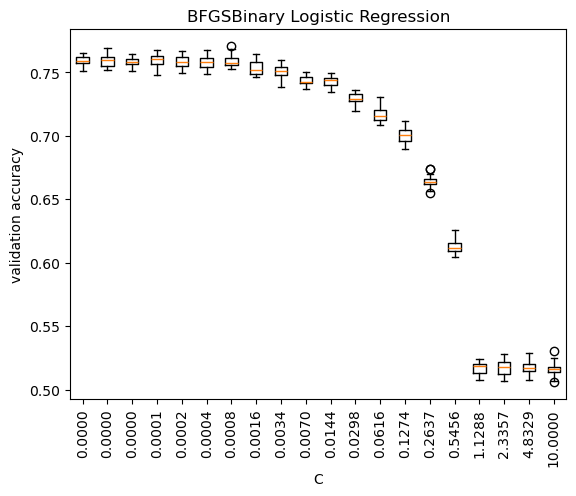

In [60]:
plt.boxplot(accs)
plt.xticks(range(1, len(costs)+1), ['%.4f'%(c) for c in costs], rotation='vertical')
plt.xlabel('C')
plt.title("BFGSBinary Logistic Regression")
plt.ylabel('validation accuracy')
plt.show()

**[1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results.**

In [61]:
%%time

def sklr_explor(cost):
  lr_clf = SKLogisticRegression(solver='liblinear', n_jobs=1,
                                multi_class='ovr', C=1/float(cost),
                                penalty = 'l2', max_iter=20)
  acc = []
  for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X, y)):
    lr_clf.fit(X[train_indices], y[train_indices]) # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set predictions
    acc.append(mt.accuracy_score(y[test_indices], y_hat))

  acc = np.array(acc)
  return acc

costs = np.logspace(-5, 1, 20)
accs = []
for c in costs:
  accs.append(sklr_explor(c))

CPU times: user 4min 38s, sys: 4min 33s, total: 9min 12s
Wall time: 1min 13s


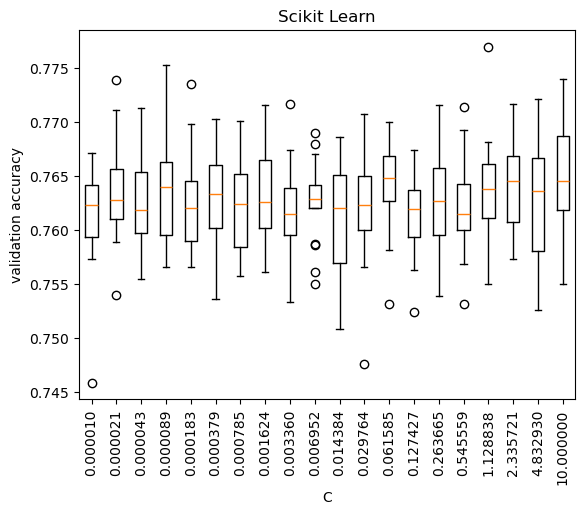

In [62]:
# THIS GRAPH NEEDS TO BE RESCALED TO FIT OUR DATA BETTER?
# now show another boxplot for the data across c
plt.boxplot(accs)
plt.xticks(range(1, len(costs)+1), ['%4f'%(c) for c in costs], rotation='vertical')
plt.xlabel('C')
plt.title("Scikit Learn")
plt.ylabel('validation accuracy')
plt.show()

**Comparison**

My best logistic regression optimization procedure is Stochastic Logistic Regression (Cell 65 to 66). Which take a total running time of 26.8 seconds, while scikit learn algorithem takes 9 minutes and 12 seconds to run. Accuracy of scikit learn is better overall with different values of Cs, but at certain points of C (such as 0.0021) they do have similar accuracy.

## Deployment (1 points total) ##

**Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party implementation)? Why?**

We suggest to use Stochastic Logistic Regression, since it is faster than scikit_learn, but we do not understand why Stochastic Logistic Regression would be faster than Scikit learn's logistic regression. We originally thought that Scikit learn is going to the fastest since Scikit's base code is written in C, perhaps the method of Stochastic Logistic Regression is just a faster algorithem than the logistic regression algorithem being used in Scikit learn regarding the running time.

Although Scikit Learn's logistic regression does have better classfication performance (accuracy) throughout all values of C (Reguluraization terms), we can always adjust C to the value that works best for the performace of Stochastic Logistic Regression. In that way the accuracy will always be high (Above 76%).

## Exceptional Work (1 points total) ##

**You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification.**

Chosen: one-versus-one multi-class classifier

After we implement the change, we tested on BFGSBinaryLogisticRegression again. In comparison of the previous visulizations (Cell 67 to 68), the running time decreased from 7 minutes and 37 seconds seconds to 1.59 seconds, and performance also increases across all values of C. So a one-versus-one multi-class classifier is actually better than a one versus all classfier.

In [63]:
from itertools import combinations

class MultiClassLogisticRegressionOvO:
  def __init__(self, eta, iterations=20,
               C=0.0001,
               penalty='12',
               solver=BFGSBinaryLogisticRegression):
    self.eta = eta
    self.iters = iterations
    self.C = C
    self.penalty = penalty
    self.solver = solver
    self.classifiers_=[]
    self.models = {} # this dictionary stores models for each class pair
    self.classes = None # this variable holds unique classes in the data set
    # sklearn conventions mean the weights will be stored as self.w_

  def __str__(self):
    if(hasattr(self, 'w_')):
      return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_) # trained the object
    else:
      return 'Untrained MultiClass Logistic Regression Object'

  def fit(self, X, y):
    self.classes = np.unique(y) # Store unique classes
    class_pairs = combinations(self.classes, 2)

    for class_pair in class_pairs:
      binary_X, binary_y = self._create_binary_dataset(X, y, class_pair[0], class_pair[1])
      hblr = self.solver(eta=self.eta, iterations=self.iters, C=self.C)
      hblr.fit(binary_X, binary_y)
      self.models[class_pair] = hblr

  def _create_binary_dataset(self, X, y, class1, class2):
    mask = (y == class1) | (y == class2)
    binary_X = X[mask]
    binary_y = np.where(y[mask] == class1, 1, 0)
    return binary_X, binary_y

  def predict_proba(self, X):
    probabilities = np.zeros((X.shape[0], len(self.classes)))

    for class_pair in self.models:
      binary_proba = self.models[class_pair].predict_proba(X)
      probabilities[:, class_pair[0]] += binary_proba.ravel()
      probabilities[:, class_pair[1]] += 1 - binary_proba.ravel()

    return probabilities

  def predict(self, X):
    probabilities = self.predict_proba(X)
    return np.argmax(probabilities, axis=1)

In [64]:
%%time

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size = 0.2, train_size=0.8)

lr = MultiClassLogisticRegressionOvO(eta=0.1,
                                     iterations = 20,
                                     C=0.001,
                                     penalty = 'l2',
                                     solver=BFGSBinaryLogisticRegression
                                     )
train_test_split(lr)

==== Iteration 0 ====
accuracy 0.7659817351598174
confusion matrix
 [[3259  236  113]
 [ 244 1158  549]
 [ 111  387  951]]
CPU times: user 1.41 s, sys: 182 ms, total: 1.59 s
Wall time: 238 ms


In [65]:
%%time

num_cv_iterations = 20
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size = 0.2)

costs = np.logspace(-5, 1, 20)
accs = []
for c in costs:
  accs.append(lr_explor(c, solver=BFGSBinaryLogisticRegression, ovr=False))

CPU times: user 6min 51s, sys: 46.4 s, total: 7min 37s
Wall time: 1min 1s


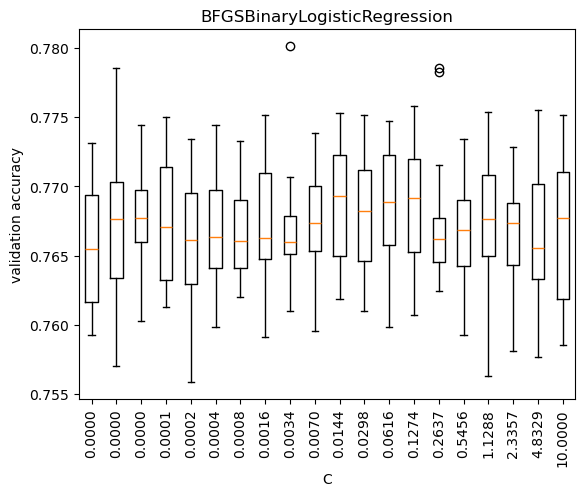

In [66]:
# now show boxplot for data across c
plt.boxplot(accs)
plt.xticks(range(1, len(costs)+1), ['%.4f'%(c) for c in costs], rotation = 'vertical')
plt.xlabel('C')
plt.title("BFGSBinaryLogisticRegression")
plt.ylabel('validation accuracy')
plt.show()